In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.util.systems import V1Circuit
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [41]:
# set fixed params

"""
base_I = 0.0
run_I = 1.0
fixed_params = {'b_E':base_I, \
                'b_P':base_I, \
                'b_S':base_I, \
                'b_V':base_I, \
                'h_RUNE':run_I, \
                'h_RUNP':run_I, \
                'h_RUNS':run_I, \
                'h_RUNV':run_I, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}"""

fixed_params = {'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}

behavior_type = "difference"

c_vals=np.array([1.0])
s_vals=np.array([60])
r_vals=np.array([0.0, 1.0])

behavior = {'type':behavior_type, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals}

# set model options
model_opts = {"g_FF": "c", "g_LAT": "square", "g_RUN": "r"}
T = 50
dt = 0.05
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

print(system.z_labels)

['$W_{EE}$', '$W_{PE}$', '$W_{SE}$', '$W_{VE}$', '$W_{EP}$', '$W_{PP}$', '$W_{VP}$', '$W_{ES}$', '$W_{PS}$', '$W_{VS}$', '$W_{SV}$', '$b_{E}$', '$b_{P}$', '$b_{S}$', '$b_{V}$', '$h_{RUN,E}$', '$h_{RUN,P}$', '$h_{RUN,S}$', '$h_{RUN,V}$', '$\\tau$']


In [42]:
M = 2000
taus = [0.15]

num_taus = len(taus)

max_I = 2.0
#base_I = np.random.uniform(0.0, max_I, (M,))
base_I = 0.15*np.ones((M,))
b_E = base_I
b_P = base_I
b_S = base_I
b_V = base_I

#run_I = np.random.uniform(0.00, max_I, (M,))
run_I = 0.3*np.ones((M,))
h_RUNE = run_I
h_RUNP = run_I
h_RUNS = run_I
h_RUNV = run_I

max_W = 5.0
max_WE = 5.0
# column 1
W_E = np.random.uniform(0.0, max_W, (M,))
W_EE = W_E
W_PE = W_E
W_SE = W_E
W_VE = W_E
"""W_EE = np.random.uniform(0.0, max_WE, (M,))
W_PE = np.random.uniform(0.0, max_WE, (M,))
W_SE = np.random.uniform(0.0, max_WE, (M,))
W_VE = np.random.uniform(0.0, max_WE, (M,))"""

# column 2
W_EP = np.random.uniform(0.0, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))
W_VP = np.random.uniform(0.0, max_W, (M,))

# column 3
W_ES = np.random.uniform(0.0, max_W, (M,))
W_PS = np.random.uniform(0.0, max_W, (M,))
W_VS = np.random.uniform(0.0, max_W, (M,))

# column 4
W_SV = np.random.uniform(0.0, max_W, (M,))

tau = np.zeros((M,))

_Z = np.stack((W_EE, W_PE, W_SE, W_VE, W_EP, W_PP, W_VP, W_ES, W_PS, W_VS, W_SV, \
               b_E, b_P, b_S, b_V, h_RUNE, h_RUNP, h_RUNS, h_RUNP, tau), axis=1)
_Z = np.expand_dims(_Z, 0)


In [43]:
num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z);

In [44]:
_T_xs = []
for i in range(num_taus):
    _tau = taus[i]
    _Z[0,:,-1] = _tau
    _T_x = sess.run(T_x, {Z:_Z});
    _T_xs.append(_T_x)


tau 0.15


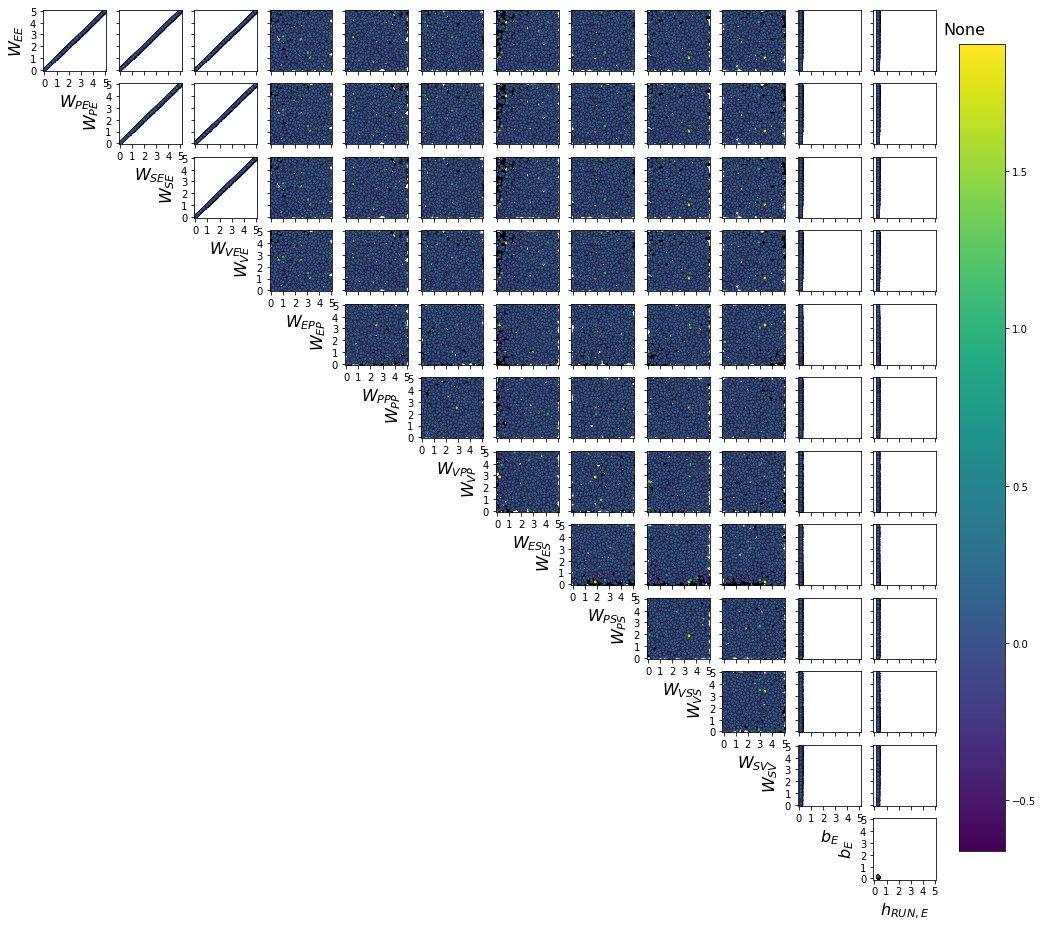

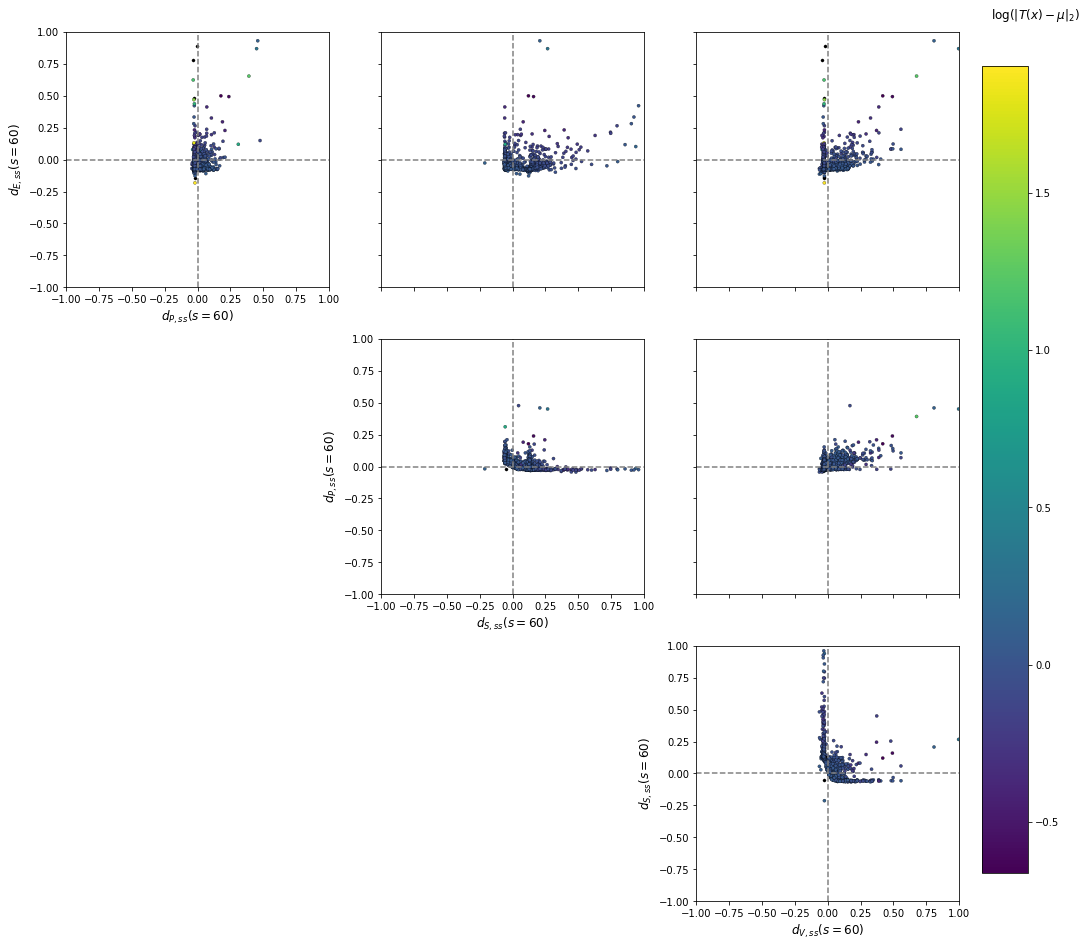

In [45]:
from operator import itemgetter
inds = [0,1,2,3,4,5,6,7,8,9,10,11,15]
nparams = len(inds)
plot_z_labels = []
for i in range(nparams):
    plot_z_labels.append(system.z_labels[inds[i]])
    
fac = 10.0
for i in range(num_taus):
    _T_x = _T_xs[i]
    _tau = taus[i]
    print('tau', _tau)
    _T_x_mu_centered = _T_x - np.expand_dims(np.expand_dims(system.mu, 0), 0)/fac
    d = np.linalg.norm(_T_x[0] - np.expand_dims(system.mu, 0), axis=1)
    d_cutoff = 10
    d[d > d_cutoff] = d_cutoff
    log_d = np.log(d)
    
    lims = [-.1, 5.1]
    ticks = np.arange(0, 6)

    fig = pairplot(_Z[0], inds, plot_z_labels, origin=False, \
                           c=log_d, c_label=None, cmap=None, \
                           xlims=lims, ylims=lims, ticks=ticks, fontsize=16, \
                           figsize=(16,16), pfname=None)
    
    fig = pairplot(_T_x_mu_centered[0], range(system.num_suff_stats//2), system.T_x_labels, origin=True, \
                       c=log_d, c_label=r'$\log(|T(x)-\mu|_2)$', cmap=None, \
                       xlims=[-1, 1], ylims=[-1, 1], ticks=None, fontsize=12, \
                       figsize=(16,16), pfname=None)

In [14]:
print(system.mu)

[-0.01333471  0.90991417  0.80966573  0.75669114  0.00375603  0.83245336
  0.66779902  0.57682998]
